In [1]:
pip install yahoofinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of tickers
tickers = ["NVDA", "MSFT", "AAPL", "AMZN", "AVGO", "META", "GOOGL", "TSLA", "GOOG", "LLY"]

# Download 3 months of daily data
data = yf.download(tickers, period="3mo", interval="1d")

# Use 'Close' data
close_data = data["Close"]

# Compute daily % change
daily_returns = close_data.pct_change() * 100

# Compute rolling 20-day volatility (annualized)
# Fill NaN with first available rolling value per ticker
rolling_volatility = (
    daily_returns.rolling(window=20, min_periods=10).std() * np.sqrt(252)
).fillna(method="bfill")

# Get beta values from Yahoo
beta_values = {t: yf.Ticker(t).info.get("beta", None) for t in tickers}

# Reshape to tidy format
df_prices = close_data.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Price")
df_returns = daily_returns.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Daily_Change_%")
df_vol = rolling_volatility.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="RollingVol_%")

# Merge everything
merged = (
    df_prices
    .merge(df_returns, on=["Date", "Ticker"], how="left")
    .merge(df_vol, on=["Date", "Ticker"], how="left")
)

# Add beta values
merged["Beta"] = merged["Ticker"].map(beta_values)

# Drop rows where data is missing for regression
merged = merged.dropna(subset=["Price", "Daily_Change_%", "RollingVol_%"]).reset_index(drop=True)

print("✅ Regression-ready dataset (sample):")
print(merged.head(10))

# Optional: save to CSV
merged.to_csv("stock_regression_ready.csv", index=False)


/tmp/ipython-input-260221409.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="3mo", interval="1d")
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-260221409.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method="bfill")


✅ Regression-ready dataset (sample):
        Date Ticker       Price  Daily_Change_%  RollingVol_%   Beta
0 2025-07-23   AAPL  213.907227       -0.116609     13.900606  1.094
1 2025-07-24   AAPL  213.517670       -0.182115     13.900606  1.094
2 2025-07-25   AAPL  213.637543        0.056142     13.900606  1.094
3 2025-07-28   AAPL  213.807358        0.079487     13.900606  1.094
4 2025-07-29   AAPL  211.030502       -1.298765     13.900606  1.094
5 2025-07-30   AAPL  208.813019       -1.050788     13.900606  1.094
6 2025-07-31   AAPL  207.334702       -0.707962     13.900606  1.094
7 2025-08-01   AAPL  202.150589       -2.500359     13.900606  1.094
8 2025-08-04   AAPL  203.119492        0.479297     13.900606  1.094
9 2025-08-05   AAPL  202.689957       -0.211469     13.900606  1.094


In [3]:
def add_features(df, close_data, daily_returns):
    """
    Adds additional derived variables for regression analysis.
    Parameters:
        df (DataFrame): The merged tidy dataframe (Date, Ticker, Price, etc.)
        close_data (DataFrame): Wide-format closing prices
        daily_returns (DataFrame): Wide-format daily returns (%)
    Returns:
        DataFrame: Original df with new variables added
    """

    # Moving averages (short and long)
    ma_10 = close_data.rolling(window=10).mean()
    ma_50 = close_data.rolling(window=50).mean()

    # Momentum (10-day percentage change)
    momentum = (close_data / close_data.shift(10) - 1) * 100

    # Volume data
    volume_data = data["Volume"]  # assuming 'data' from your script above

    # Relative Strength Index (RSI)
    delta = close_data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    # Convert all features to tidy format
    ma_10_df = ma_10.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="MA10")
    ma_50_df = ma_50.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="MA50")
    momentum_df = momentum.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Momentum_%")
    rsi_df = rsi.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="RSI")
    volume_df = volume_data.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Volume")

    # Merge them all
    df = (
        df.merge(ma_10_df, on=["Date", "Ticker"], how="left")
          .merge(ma_50_df, on=["Date", "Ticker"], how="left")
          .merge(momentum_df, on=["Date", "Ticker"], how="left")
          .merge(rsi_df, on=["Date", "Ticker"], how="left")
          .merge(volume_df, on=["Date", "Ticker"], how="left")
    )

    # Drop rows with missing feature values
    df = df.dropna(subset=["MA10", "MA50", "Momentum_%", "RSI", "Volume"])

    return df


In [4]:
# Add new features to your regression-ready dataset
merged = add_features(merged, close_data, daily_returns)

print("✅ Enhanced dataset with extra features:")
print(merged.head(10))

# Save to CSV
merged.to_csv("stock_regression_enhanced.csv", index=False)


✅ Enhanced dataset with extra features:
         Date Ticker       Price  Daily_Change_%  RollingVol_%   Beta  \
48 2025-09-30   AAPL  254.630005        0.078612     28.933664  1.094   
49 2025-10-01   AAPL  255.449997        0.322033     26.214950  1.094   
50 2025-10-02   AAPL  257.130005        0.657666     26.228289  1.094   
51 2025-10-03   AAPL  258.019989        0.346122     26.185946  1.094   
52 2025-10-06   AAPL  256.690002       -0.515459     26.061428  1.094   
53 2025-10-07   AAPL  256.480011       -0.081807     25.181823  1.094   
54 2025-10-08   AAPL  258.059998        0.616027     21.072469  1.094   
55 2025-10-09   AAPL  254.039993       -1.557779     22.253746  1.094   
56 2025-10-10   AAPL  245.270004       -3.452208     25.776337  1.094   
57 2025-10-13   AAPL  247.660004        0.974436     25.714379  1.094   

          MA10        MA50  Momentum_%        RSI    Volume  
48  250.657999  230.091276    6.920013  82.768379  37704300  
49  252.303998  230.917137    6.

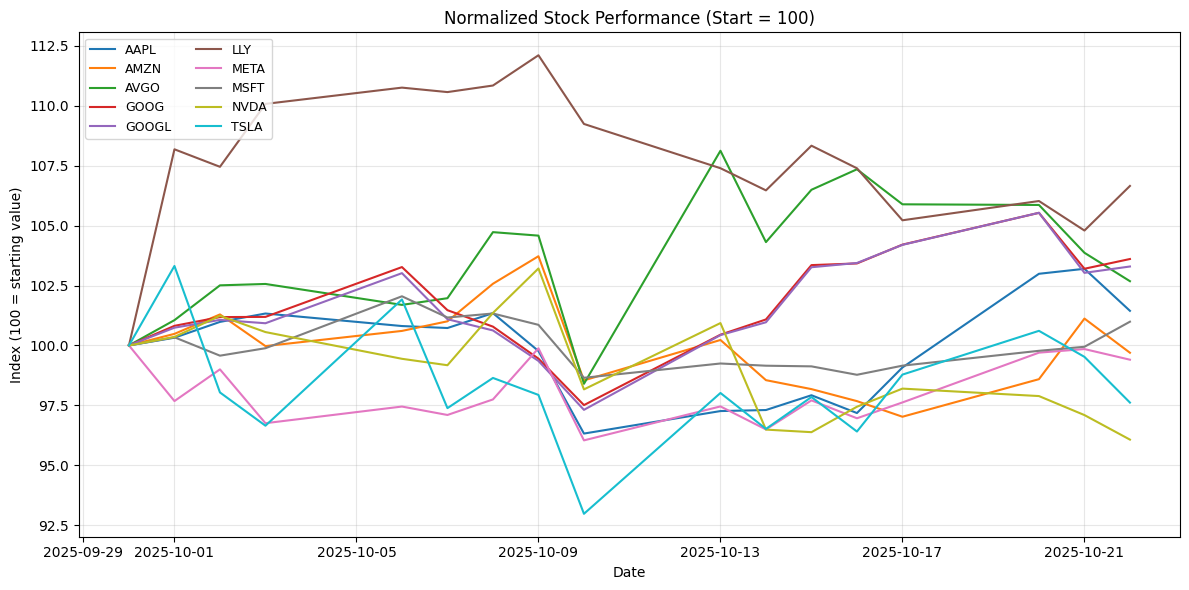

In [5]:
# Normalize prices to start at 100
# Pivot data to wide format for plotting
price_pivot = merged.pivot(index="Date", columns="Ticker", values="Price")

normalized = price_pivot / price_pivot.iloc[0] * 100

plt.figure(figsize=(12, 6))
for ticker in normalized.columns:
    plt.plot(normalized.index, normalized[ticker], label=ticker)

plt.title("Normalized Stock Performance (Start = 100)")
plt.xlabel("Date")
plt.ylabel("Index (100 = starting value)")
plt.legend(loc="upper left", ncol=2, fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

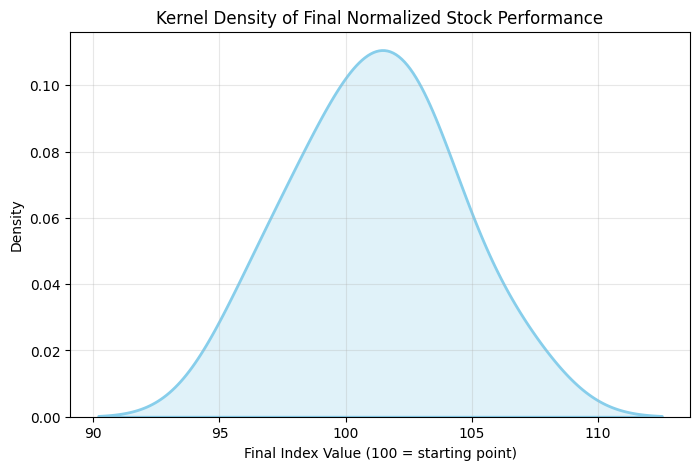

In [6]:
# Option 1: KDE of final normalized values (e.g., final performance)
final_values = normalized.iloc[-1]

plt.figure(figsize=(8, 5))
sns.kdeplot(final_values, fill=True, color="skyblue", linewidth=2)
plt.title("Kernel Density of Final Normalized Stock Performance")
plt.xlabel("Final Index Value (100 = starting point)")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()